# AWG Phase Calibration
The goal of this experiment is to demonstrate phase calibration of a VNA on an arbitrary frequency grid using a arbitrary waveform generator. We do this by creating a phase reference signal on one port (port 4), and a series of sine waves on port 1. We then measure those sine waves with a calibrated oscilloscope.   

## Imports

In [1]:
# import the pyMez packages default API
from pyMez import *
# import the Fitting module for Signal Generation and Fitting, note the namespace Code.Analysis.Fitting also works
from pyMez.Code.Analysis.Fitting import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 1.465 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.314 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
It took 2.246 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
It took 0.031 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.268 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.033 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 5.411 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.009 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.

## Global Variable Declaration 
This experiment involves the PSG, VNA, AWG,power meter, Scope and 2 combs. The addresses of the instruments and the top level data directory are assumed to be fixed throughout the course of the experiment. 

In [2]:
# none of these instruments have xml instrument sheets, need to add them
psg_address="GPIB0::19"
vna_address="GPIB0::16"
awg_address="GPIB0::10"
scope_address="GPIB0::7::INSTR"
pm_address="GPIB0::13"
# this is local to the computer taking the data, the data should be copied to Q:\public\Aric\AWG_Phase_Calibration_20180927
data_directory=r'C:\Share\AWG_Phase_Calibration_20181001'


In [250]:
# Experimental variables

# the psg frequency acts as the master clock
psg_amplitude=12. #psg amplitude in dBm
psg_frequency=10.*10.**9 # 10 GHz
time_step=1./psg_frequency # time step for the awg

# Calculation of the frequency grid of interest
fundamental_frequency = 1.*10.**9 # Center of the passband or fundemental frequency in Hz
number_tones = 11 # Number of tones in the modulation bandwidth including the fundamental, should be odd
tone_spacing = 20*10**3 # Spacing of each tone. Combs can do 10 Mhz, 5 MHz, 2.5 MHz, 1.25 MHz and .625 MHz
number_harmonics = 1 # Number of harmonics to use. The frequency grid will be n*(f-df), n*f, n*(f+df), etc
# now calculate the frequency_list
frequency_list=[]
for harmonic in range(number_harmonics):
    frequency_array=np.linspace((harmonic+1)*(fundamental_frequency-tone_spacing*(number_tones-1)/2),
                                (harmonic+1)*(fundamental_frequency+tone_spacing*(number_tones-1)/2),number_tones)
    frequency_list=frequency_list+frequency_array.tolist()
# Select the phase for the multisine    
#multisine_phase="zero"
multisine_phase="schroeder"
# select the number of envelopes
number_envelopes=1.
time_max=number_envelopes/tone_spacing
number_time_points=int(round(time_max/time_step))
time_shift=0.*time_step
# Measurement Phase Reference Setup 
round_multisine_before_writing=True # Rounds the multisine to a desired bitdepth before writing to AWG
bit_depth=8
waveform_name="Calibration_Phase_Reference" # name of the waveform to write to the 
bin_format=True # If the wave is in 16 bit bin format
marker_1=True # If marker one is to be set
marker_1_n_repeats=1 # the rep rate of the marker as a function of number of repeats per time sequence
marker_2=False
marker_2_n_repeats=1

In [255]:
frequency_list

[999900000.0,
 999920000.0,
 999940000.0,
 999960000.0,
 999980000.0,
 1000000000.0,
 1000020000.0,
 1000040000.0,
 1000060000.0,
 1000080000.0,
 1000100000.0]

## Instrument Control Verification
This verifies that the instruments are attached and responding properly

In [182]:
whos_there()

Agilent Technologies,86100C,MY47440684,A.08.00
 is at address GPIB0::7::INSTR
Agilent Technologies,E4417A,SG55376002,A2.05.04
 is at address GPIB0::13::INSTR
TEKTRONIX,AWG7122B,B020393,SCPI:99.0 FW:4.6.0.7 
 is at address GPIB0::10::INSTR
Agilent Technologies, E8267D, US46470659, C.05.26
 is at address GPIB0::19::INSTR
Agilent Technologies,N5245A,SG49151009,A.10.64.03
 is at address GPIB0::16::INSTR


## PSG Setup
The PSG is a vector signal generator manufactured by Agilent (model number 8267D). It is directly used as the clock for the AWG and inputs for IQ on the oscilloscope. It has to remain at the specified frequency for the duration of the experiment. In the first attempts we are using a 10 GHz sine wave with an amplitude of 12 dBm.

In [8]:
# first intialize a class to talk with the psg
psg=VisaInstrument(psg_address)
# verify that it is properly connected
print("The psg IDN is {0}".format(psg.query("*IDN?")))
# Make sure the mode is CW
print("The psg is in the {0} mode".format(psg.query("FREQ:MODE?")))

The information sheet was not found defaulting to address
The psg IDN is Agilent Technologies, E8267D, US46470659, C.05.26

The psg is in the CW
 mode


In [ ]:
# Only run this if the PSG was not already setup using the front panel
# This can be done in a single step if there is a saved xml state by using psg.load_state(path_to_xml_state)
# set the psg mode
psg.write("FREQ:MODE CW")
# set the amplitude
psg.write("POW:AMPL {0}".format(psg_amplitude))
# set the frequency
psg.write("FREQ:CW {0}".format(psg_frequency))
# turn the output on
psg.write("OUTP 1")

In [10]:
# Now get the state and save it
# We can do this one at a time or all at once
psg_state_name=auto_name(directory=data_directory,specific_descriptor="psg",general_descriptor="state",extension="xml")
psg_state_query_dictionary={"FREQ:MODE":"FREQ:MODE?","POW:AMPL":"POW:AMPL?","FREQ:CW":"FREQ:CW?","OUTP":"OUTP?"}
psg_state=psg.get_state(psg_state_query_dictionary)
state_path=os.path.join(data_directory,psg_state_name)
psg.save_state(state_path=state_path,state_dictionary=psg_state)

'C:\\Share\\AWG_Phase_Calibration_20181001\\psg_state_20181003_001.xml'

## AWG setup
Now that the PSG or master clock has been set up we must now setup the AWG (Tektronix Model AWG67122B). First we calculate the multi-sine used as a reference on port 4 of the VNA. It should contain all of the frequency components we expect to measure during the course of the experiment. The number of points required to faithfully represent this signal depends on the frequency grid and the master clock frequency set by the PSG. The length of the waveform chunk to be written is limited to 650 M Bytes where data written in Real format takes up 5 bytes. The fifth byte is the marker data.

In [251]:
# first create the multisine
sine_function=FunctionalModel(parameters=["f","phi"],variables=["t"],equation="cos(2*pi*f*t+phi)")
time_list=np.linspace(0.+time_shift,time_max+time_shift-time_step,number_time_points)

# calculate the phases 
phase_list = [0. for i in range(len(frequency_list))]
if re.search("sch",multisine_phase,re.IGNORECASE):
    phase_list=[]
    for frequency_index,frequency in enumerate(frequency_list):
        k=(frequency_index+1)%number_tones
        schroeder_phase=-k*(k-1)*np.pi/number_tones
        phase_list.append(schroeder_phase)
# initialize multisine to a set of zeros
multisine=np.array([0 for i in range(number_time_points)])
# add each component
for frequency_index,frequency in enumerate(frequency_list):
    sine_function.set_parameters({"f":frequency,"phi":phase_list[frequency_index]})
    multisine_component=sine_function(time_list)
    multisine=multisine+multisine_component
    
# substract the mean
# multisine=multisine-np.mean(multisine)
# normalize the multisine
# multisine=1/max(multisine)*multisine

# round the multisine to the nearest bitdepth before writing
if round_multisine_before_writing:
    discrete_steps=np.linspace(min(multisine),max(multisine),2**bit_depth)
    rounded_multisine=[]
    int_multisine=[]
    for value in multisine:
        difference_array=abs(discrete_steps-value)
        minimum_location=np.argmin(difference_array)
        rounded_multisine.append(discrete_steps[minimum_location])
        int_multisine.append(minimum_location)
    if bin_format:
        multisine=np.array(int_multisine,dtype=np.uint16)
        # Shift, now to add the marker add + 2**14 or +2**15 at the desired location
        multisine=multisine*2**6
    else:
        multisine=rounded_multisine
        
# now we add the marker. 
if marker_1:
    
    distance=int(np.floor(float(len(multisine))/float(marker_1_n_repeats)))
    for i in range(marker_1_n_repeats):
        try:
            multisine[i*distance]=multisine[i*distance]+2**14
        except:
            pass
        

In [86]:
multisine[0]

4480

In [79]:
print("Length of discrete steps: {0}".format(len(discrete_steps)))
print("Max value of int_multisine: {0}".format(max(int_multisine)))

Length of discrete steps: 256
Max value of int_multisine: 255


## Verify the Multisine before writing to the AWG

Mean Value : 8160.04096
Length of Waveform: 500000


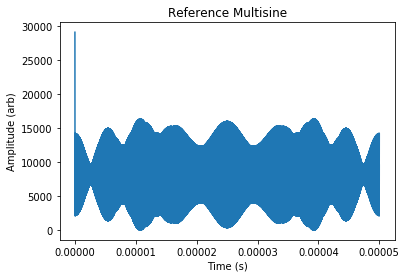

In [252]:
# Time Domain Plot
plt.plot(time_list,multisine,label="Multisine")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (arb)")
plt.title("Reference Multisine")
print("Mean Value : {0}".format(np.mean(multisine)))
print("Length of Waveform: {0}".format(len(multisine)))
plt.show()

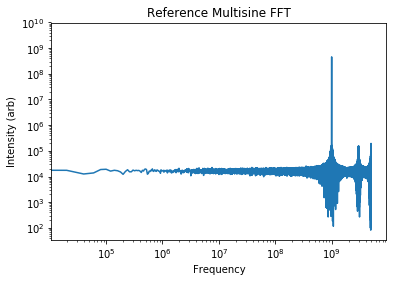

In [257]:
# Power Spectrum
plt.close()
multisine_fft=np.fft.fft(multisine)
fft_frequency_list=np.linspace(0,1/(2*time_step),number_time_points//2)
plt.loglog(fft_frequency_list,abs(multisine_fft[0:number_time_points//2]))
plt.xlabel("Frequency")
plt.ylabel("Intensity (arb)")
plt.title("Reference Multisine FFT")
#plt.xlim([min(frequency_list)-2*tone_spacing,max(frequency_list)+2*tone_spacing])
plt.show()

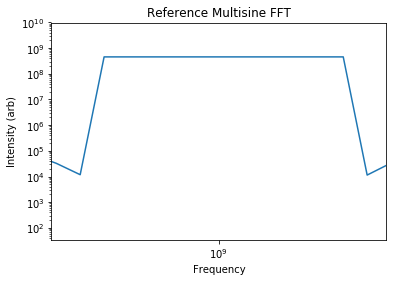

In [258]:
# Power Spectrum Zoomed In 
plt.close()
multisine_fft=np.fft.fft(multisine)
fft_frequency_list=np.linspace(0,1/(2*time_step),number_time_points//2)
plt.loglog(fft_frequency_list,abs(multisine_fft[0:number_time_points//2]))
plt.xlabel("Frequency")
plt.ylabel("Intensity (arb)")
plt.title("Reference Multisine FFT")
plt.xlim([min(frequency_list)-2*tone_spacing,max(frequency_list)+2*tone_spacing])
plt.show()

## Write Measurement Phase Reference to the AWG

In [18]:
# create a control class for the awg
awg=VisaInstrument(awg_address)
# verify it is connected and working properly
awg.query("*IDN?")

The information sheet was not found defaulting to address


u'TEKTRONIX,AWG7122B,B020393,SCPI:99.0 FW:4.6.0.7 \n'

## Write to Channel 1 and Channel 2 of the AWG
The waveform on Channel 1 and Channel 2 have to be the same length before running the AWG, so we define them both as the measurement reference waveform at first

In [254]:
# I am guessing that this has the possibility of kiling the oscope trigger
if bin_format:
    # turn AWG's output 1 & 2 OFF
    awg.write(':OUTPUT1:STATE OFF')
    awg.write(':OUTPUT2:STATE OFF')
    # wait...
    time.sleep(0.1)
    # UNRUN state
    awg.write('AWGCONTROL:STOP')
    # wait...
    time.sleep(0.5)

    # delete any older waveform with the same name
    awg.write('WLISt:WAVeform:DELete "{0}"'.format(waveform_name))
    time.sleep(0.05)

    # create new waveform
    awg.write('WLISt:WAVeform:NEW "{0}", {1}, INT'.format(waveform_name,len(multisine)))
    # download data
    awg.resource.write_binary_values('WLISt:WAVeform:DATA "{0}",'.format(waveform_name), multisine, datatype='H', is_big_endian=False)
    time.sleep(0.1)
    # assign new waveform to channel 1 & 2
    awg.write('SOURce1:WAVeform "{0}"'.format(waveform_name))
    awg.write('SOURce2:WAVeform "{0}"'.format(waveform_name))

    # check for errors
    error_str = awg.query('SYSTEM:ERROR:NEXT?')
    # wait...
    time.sleep(.1)
    # AWG on RUN state
    awg.write('AWGCONTROL:RUN')
    # wait...
    time.sleep(0.5)
    # check if there is any errors on AWG's buffer
    error_str = awg.query('SYSTEM:ERROR:NEXT?')
    if error_str == '0,"No error"\n':
        # turn AWG's output 1 OFF
        awg.write(':OUTPUT1:STATE ON')
        awg.write(':OUTPUT2:STATE ON')


In [36]:

awg.write(':OUTPUT1:STATE ON')
awg.write(':OUTPUT2:STATE ON')

(19L, <StatusCode.success: 0>)

In [44]:
awg.query('SYSTEM:ERROR:NEXT?')

u'0,"No error"\n'

## Setting up the VNA

In [279]:
vna=VNA(vna_address)

The information sheet was not found defaulting to address


In [ ]:
vna.add_trace("a1_a4","r1r4")

## Setting up the Oscilloscope

In [184]:
scope=HighSpeedOscope(scope_address)

The information sheet was not found defaulting to address


In [185]:
scope.get_trigger_source()

In [194]:
scope.query("TRIG:SOUR?")

u'FPAN\n'

In [193]:
scope.set_trigger_source(source="FPAN")

In [262]:
scope.set_number_points(100)
wave=scope.measure_waves(number_frames=1000)

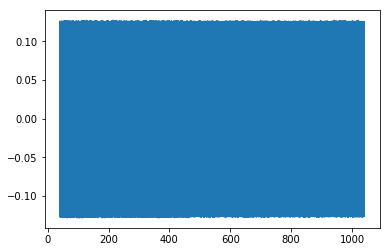

In [263]:
plt.plot(wave["Time"],wave["CHAN2"])
plt.show()

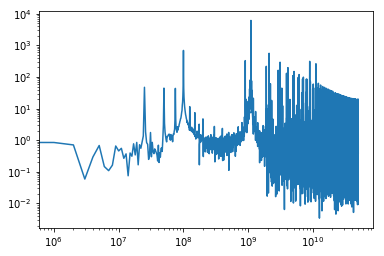

In [264]:
wave_fft=np.fft.fft(wave["CHAN2"])
delta_time=(wave["Time"][1]-wave["Time"][0])*10**-9
fft_frequency_list=np.linspace(0,1./(2.*delta_time),len(wave["Time"])//2)
plt.loglog(fft_frequency_list,abs(wave_fft[0:len(wave["Time"])//2]))
plt.show();

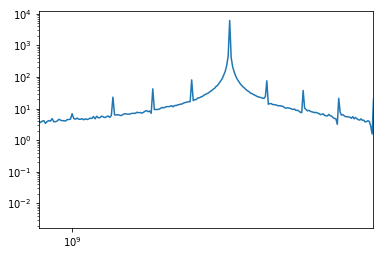

In [274]:
wave_fft=np.fft.fft(wave["CHAN2"])
delta_time=(wave["Time"][1]-wave["Time"][0])*10**-9
fft_frequency_list=np.linspace(0,1./(2.*delta_time),len(wave["Time"])//2)
plt.loglog(fft_frequency_list,abs(wave_fft[0:len(wave["Time"])//2]))
plt.xlim([9.8*10**8,.12*10**10])
plt.show();

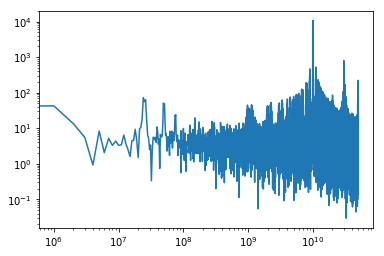

In [265]:
wave_fft=np.fft.fft(wave["CHAN3"])
delta_time=(wave["Time"][1]-wave["Time"][0])*10**-9
fft_frequency_list=np.linspace(0,1./(2.*delta_time),len(wave["Time"])//2)
plt.loglog(fft_frequency_list,abs(wave_fft[0:len(wave["Time"])//2]))
plt.show();

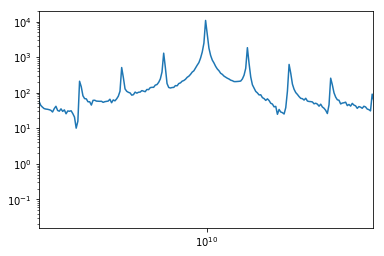

In [278]:
wave_fft=np.fft.fft(wave["CHAN3"])
delta_time=(wave["Time"][1]-wave["Time"][0])*10**-9
fft_frequency_list=np.linspace(0,1./(2.*delta_time),len(wave["Time"])//2)
plt.loglog(fft_frequency_list,abs(wave_fft[0:len(wave["Time"])//2]))
plt.xlim([9.9*10**9,1.01*10**10])
plt.show();